In [2]:
import numpy as np
from numba import vectorize, complex64, boolean, jit
from PIL import Image
import tensorflow as tf
import os, sys, itertools, time

import keras
import itertools

from keras.layers         import Dense
from keras.layers         import Dropout
from keras.models         import Model
from keras.models         import Sequential
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
@jit
def f(z, c):   #iterating function
    return z * z + c
@jit
def does_diverge(z, c, iters):  #checks if a given pixel diverges
#     iters = 3
    for _ in range(iters):
        z = f(z, c)
        if abs(z) > 2: # Diverges
            return 1
    return 0
# Credit to https://aboveintelligent.com/what-do-deep-neural-networks-understand-of-fractals-2ae354911601
def generate_julia_set(size, c=False, iterations=50):
    x = np.linspace(-2, 2, size * 3)
    y = np.linspace(-1, 1, size * 2)
    X = np.array(list(itertools.product(y, x)))[:, (1, 0)]
    if not c:
        output = np.array([does_diverge(sample[0]+1j*sample[1], sample[0]+1j*sample[1], iterations) for sample in X])
    else:
        output = np.array([does_diverge(sample[0]+1j*sample[1], c, iterations) for sample in X])
    return X, output.reshape((size * 2, size * 3)) #image format

In [14]:
max_iter = 50 # 50 is standard

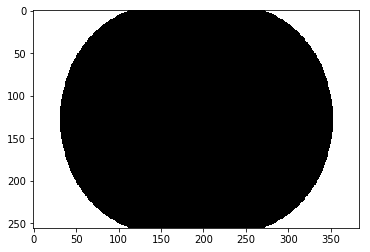

0.5337328910827637


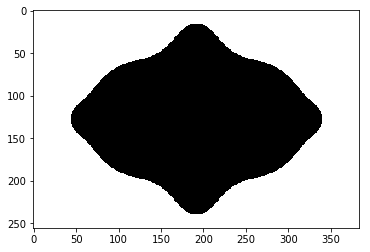

0.5098590850830078


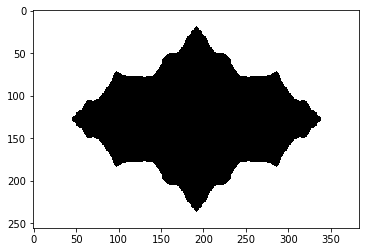

0.5851767063140869


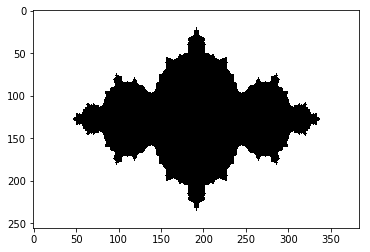

0.6056280136108398


In [6]:
@jit
def plot_fractal(c, iterations=50):
    start = time.time()
    X, res = generate_julia_set(128, c=c, iterations=iterations)
    plt.figure()
    ax = plt.imshow(res, cmap = 'gray')
    ax = plt.gca()
    ax.grid(linewidth=0)
    plt.show()
    end = time.time()
    save_array("res", res)
    print(end-start)
    return X, res
@jit
def plot_fractal_exculdeblack(c): #sometimes the fractals are all black,, exclude this
    start = time.time()
    X, res = generate_julia_set(128, c=c)
    if (np.mean(res)>.99):    #this image is all black
        return False
    return res
X, res = plot_fractal(-.8, 1)
X, res = plot_fractal(-.8, 3)
X, res = plot_fractal(-.8, 5)
X, res = plot_fractal(-.8, 9)

In [19]:
@jit
def save_img(matrix, X, c, filename="default.txt"): # Takes in a 2d numpy array, np array of [x, y] pairs, c value
    file = open(filename, 'w')
    matrix = matrix.flatten()    #flatten 2d array of divergence values
    file.write(str(c)+'\n')
    file.write("X <-Float, Y <-Float, Diverges <-Boolean\n")
    for div, xy in zip(matrix, X):
        file.write(str(xy[0]) +" "+ str(xy[1]) +" "+ str(div) +" "+ "\n")
    file.close()
@jit
def load_img(filename): # Takes in a filename and returns a [x, y] range and a 2d array of divergence values
    file = open(filename, 'r')
    text = file.read()
    print(c)
    file.close()
@jit
def save_ctoimg_txt(clist, filelist, txtfile): #Saves a list of c and image file name mappings
    file = open(txtfile, 'w')
    for c, filename in zip(clist, filelist):
        line = filename +" "+ str(c[0])+" "+str(c[1])+"i"+"\n"
        file.write(line)
    file.close()

In [5]:
@jit
def save_array(filename, array): # don't add a filename so it saves as .npy as default
    np.save(filename, array)
@jit
def load_array(filename):
    return np.load(filename)

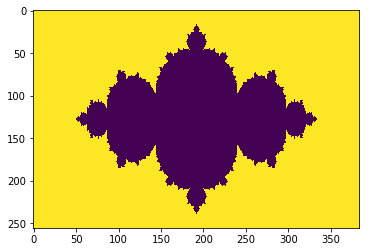

In [6]:
arr = load_array('res.npy')
plt.figure()
plt.imshow(arr)

In [8]:
# This code generates the data folder
@jit
def generate_dataset(num_samples, fileindex, npyfilename, txtfilename):
    xy = []
    for i in range(num_samples):
        randr = np.random.uniform(-2, 2)
        randi = np.random.uniform(-1, 1)
        xy.append([randr, randi])
    rrange = range(len(xy))
    xy = np.array(xy)
    count = fileindex
    clist = []
    filelist = []
    for i in xy:
        c = i[0]+1j*i[1]   #construct complex value
        output = plot_fractal_exculdeblack(i[0]+1j*i[1])
        if type(output) != bool:    #res is returned
            clist.append(i)
            filename = npyfilename+str(count)
            filelist.append(filename)
            save_array(filename, output)
            count += 1
    save_ctoimg_txt(clist, filelist, txtfile=txtfilename)

In [72]:
generate_dataset(10000, 0, "data/julia", "data/meta/cvalues.txt")

FileNotFoundError: [Errno 2] No such file or directory: 'data/julia0.npy'

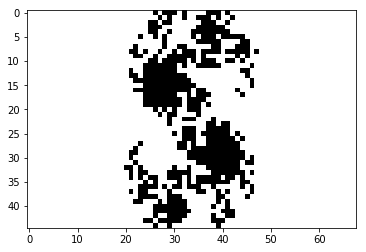

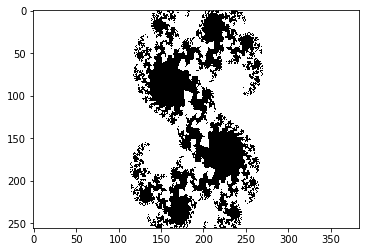

In [233]:
# Example of loading from the data folder
for i in range(48,49):
    plt.figure()
    aa = load_array("data/julia"+str(i)+".npy")
    factor = 0.18
    a = subSample(aa, factor, True)

In [ ]:
# Courtesy of 189 hw4 solutions
@jit
def assemble_feature(X, D):
    xs = []
    for d0 in range(D + 1):
        for d1 in range(D - d0 + 1):
            xs.append((X[:, 0]**d0)*(X[:, 1]**d1))
    return np.column_stack(xs)

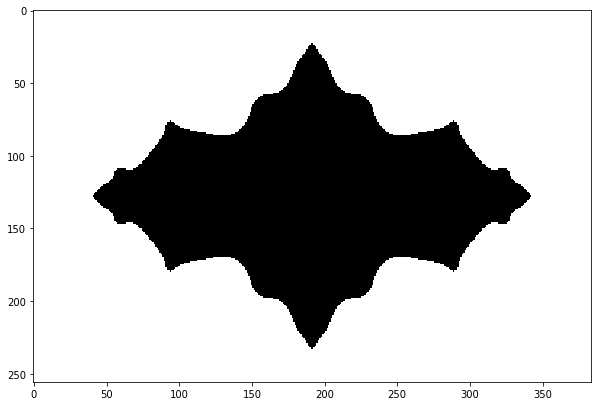

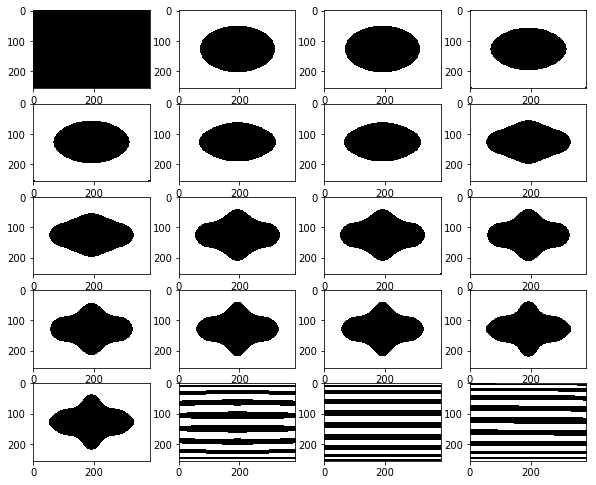

In [69]:
### Simple Regression ###
b = np.ndarray.flatten(res)
plt.figure(figsize=(10,10))
plt.imshow(res, cmap="gray")
plt.figure(figsize=(10,10))
for i in range(1, 21):
    A = X
    A = np.hstack([assemble_feature(A, i)])
#     print(A)
    w = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)
#     print(w)x
    
    img = np.reshape(A.dot(w), (128*2, 128*3))
    img[img < .5] = 0
    img[img >=.5] = 1
    
    plt.subplot(6,4,i)
    plt.imshow(img, cmap="gray")

In [114]:
save_array("X_abvalues", X)

(45, 68)


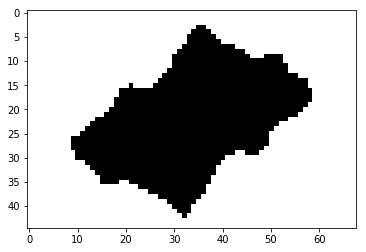

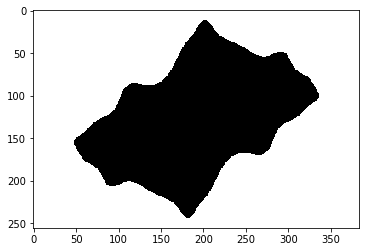

In [10]:
def subSample(anArray, reductionFactor,shouldDraw=False):
    #Note that reductionFactor is a float between 0 and 1
    #Also note reductionFactor is per dimension (so for us, the true size reduction is
    #   reductionFactor squared)
    xSamples = np.linspace(0,255,int(255*reductionFactor),dtype=int)
    ySamples = np.linspace(0,383,int(383*reductionFactor),dtype=int)
    ans = anArray[np.ix_(xSamples, ySamples)]
    if shouldDraw:
        plt.figure()
        plt.imshow(ans, cmap="gray")
        plt.figure()
        plt.imshow(anArray, cmap="gray")
    return ans


factor = 0.18
a = subSample(res, factor, True)
print(a.shape)


# Data X, Y filling

In [231]:
factor = 0.18
txt = open("data/meta/cvalues.txt")
X_ab= np.load("X_abvalues.npy")
X_ab = X_ab.reshape(256, 384, 2)
X_ab = subSample(X_ab, factor)
X_ab = np.reshape(X_ab, (45*68, 2))
X = []
Y = []
for desc, imgnum in zip(txt, range(2152)): #2151+1 since top range is exclusive
    Fname, a, b = desc.split()
    b = b[:-1] # remove the 'i' at the end
    arr = np.load("./data/julia"+str(imgnum)+".npy")
    arr = subSample(arr, factor)
    arr = np.ndarray.flatten(arr)
    Y.extend(arr)
    for coord in X_ab:
        a, b = float(a), float(b)
        X.append([float(coord[0]), float(coord[1]), a, b])
X = np.array(X)
Y = np.array(Y)
print(X)
print(X.shape)
print("___")
print(Y)
print(Y.shape)
save_array('X', X)
save_array('Y', Y)
   

[[-2.         -1.         -0.12584225  0.05355327]
 [-1.94778068 -1.         -0.12584225  0.05355327]
 [-1.88511749 -1.         -0.12584225  0.05355327]
 ...
 [ 1.87467363  1.         -0.13967531 -0.68114153]
 [ 1.93733681  1.         -0.13967531 -0.68114153]
 [ 2.          1.         -0.13967531 -0.68114153]]
(6585120, 4)
___
[1 1 1 ... 1 1 1]
(6585120,)


In [181]:
arr = np.load("./data/julia"+str(1)+".npy")

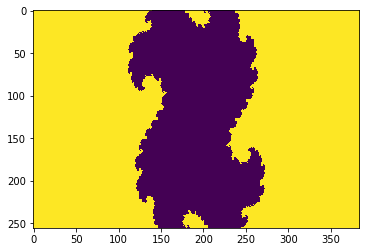

In [182]:
plt.imshow(arr)

In [237]:
txt = open("data/meta/cvalues.txt")
X = []
for desc in txt: #2151+1 since top range is exclusive
    Fname, a, b = desc.split()
    b = b[:-1] # remove the 'i' at the end
    a, b = float(a), float(b)
    X.append([a, b])
X = np.array(X)
print(X)
print(X.shape)
save_array('C_values', X)
   

[[-0.12584225  0.05355327]
 [ 0.32086338 -0.08358595]
 [-0.45608656 -0.37586788]
 ...
 [-1.00921746 -0.18455224]
 [-0.64422139 -0.07463499]
 [-0.13967531 -0.68114153]]
(2152, 2)
